
=== Stage 1: Training network on reference image ===
Spectrogram shape: torch.Size([96, 64])
Spectrogram range: 0.000000 to 1.000000
Mean: 0.393003, Std: 0.161755
Step 0, loss=0.106878


/opt/anaconda3/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


Step 100, loss=0.049525
Step 200, loss=0.025879
Step 300, loss=0.036739
Step 400, loss=0.018265
Step 500, loss=0.023671
Step 600, loss=0.032031
Step 700, loss=0.015652
Step 800, loss=0.016801
Step 900, loss=0.013817
Training complete!


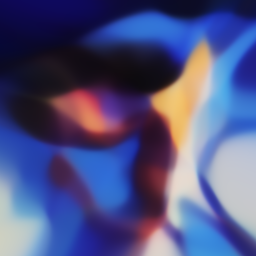


=== Generating video for liability.wav ===
Spectrogram shape: torch.Size([601, 64])
  Saved 50/601 frames
  Saved 100/601 frames
  Saved 150/601 frames
  Saved 200/601 frames
  Saved 250/601 frames
  Saved 300/601 frames
  Saved 350/601 frames
  Saved 400/601 frames
  Saved 450/601 frames
  Saved 500/601 frames
  Saved 550/601 frames
  Saved 600/601 frames
Creating video...
Adding audio...
✓ Video saved: liability_final.mp4


=== Generating video for one_last_kiss.wav ===
Spectrogram shape: torch.Size([301, 64])


/opt/anaconda3/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


  Saved 50/301 frames
  Saved 100/301 frames
  Saved 150/301 frames
  Saved 200/301 frames
  Saved 250/301 frames
  Saved 300/301 frames
Creating video...
Adding audio...
✓ Video saved: one_last_kiss_final.mp4


=== Generating video for city_of_stars.wav ===
Spectrogram shape: torch.Size([271, 64])


/opt/anaconda3/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


  Saved 50/271 frames
  Saved 100/271 frames
  Saved 150/271 frames
  Saved 200/271 frames
  Saved 250/271 frames
Creating video...
Adding audio...
✓ Video saved: city_of_stars_final.mp4



In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image, ImageDraw
from IPython.display import display
import matplotlib.pyplot as plt
import torchaudio
import os
import subprocess
import shutil

# --------------------------
# 1) Network
# --------------------------
class XYSpecNet(nn.Module):
    def __init__(self, spec_dim=64, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2 + spec_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 3),
            nn.Sigmoid()
        )

    def forward(self, xy_spec):
        return self.net(xy_spec)

# --------------------------
# 2) Parameters
# --------------------------
H, W = 256, 256
hidden = 64
latent_size = 64
target_fps = 30
target_img_path = "target.png"
# Random-walk parameters 
steps_per_frame = 600     # how many strokes per video frame

# --------------------------
# 3) Coordinate grid (normalized)
# --------------------------
xs = torch.linspace(-1, 1, W)
ys = torch.linspace(-1, 1, H)
xx, yy = torch.meshgrid(xs, ys, indexing='xy')
coords = torch.stack([xx.flatten(), yy.flatten()], dim=1)

# --------------------------
# Helper functions 
# --------------------------
def make_mel_spec(audio_file, latent_size, target_fps):
    """Load audio_file and return mel spectrogram with shape [T, latent_size]."""
    audio, sr = torchaudio.load(audio_file, normalize=True)
    audio = audio[0]  # first channel

    hop_length = int(sr / target_fps)

    transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr,
        n_fft=hop_length * 2,
        n_mels=latent_size,
        hop_length=hop_length,
        win_length=hop_length * 2
    )

    spec = transform(audio).T  # [T, latent_size]
    return spec

def normalize_spec(spec, spec_min=None, spec_max=None):
    """Apply log + min-max normalize to [0,1]. If min/max not provided, compute them."""
    spec = torch.log(spec + 1e-9)

    if spec_min is None:
        spec_min = spec.min()
    if spec_max is None:
        spec_max = spec.max()

    spec = (spec - spec_min) / (spec_max - spec_min + 1e-8)
    return spec, spec_min, spec_max

def make_model_input(coords, spec_frame, H, W):
    """coords: [H*W,2], spec_frame: [latent_size] -> inp: [H*W, 2+latent_size]"""
    music_vec = spec_frame.unsqueeze(0).repeat(H * W, 1)  # [H*W, latent_size]
    inp = torch.cat([coords, music_vec], dim=1)           # [H*W, 2+latent_size]
    return inp

# --------------------------
# STAGE 1: Train on target image with ALL spectrogram frames
# --------------------------
print("\n=== Stage 1: Training network on reference image ===")

audio_path = "audio.wav"
raw_spec = make_mel_spec(audio_path, latent_size, target_fps)
spectrogram, spec_min, spec_max = normalize_spec(raw_spec)

print(f"Spectrogram shape: {spectrogram.shape}")
print(f"Spectrogram range: {spectrogram.min():.6f} to {spectrogram.max():.6f}")
print(f"Mean: {spectrogram.mean():.6f}, Std: {spectrogram.std():.6f}")

# Load target image
target_img = Image.open(target_img_path).convert("RGB").resize((W, H))
target_rgb = np.asarray(target_img, dtype=np.float32) / 255.0
target_tensor = torch.from_numpy(target_rgb.reshape(-1, 3))

model = XYSpecNet(spec_dim=latent_size, hidden=hidden)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

train_frame_indices = np.random.choice(len(spectrogram), size=min(50, len(spectrogram)), replace=False)
train_specs = spectrogram[train_frame_indices]  # [num_train_frames, latent_size]

for step in range(1000):
    optimizer.zero_grad()

    idx = np.random.randint(0, len(train_specs))
    spec_frame = train_specs[idx]

    inp_train = make_model_input(coords, spec_frame, H, W)

    pred = model(inp_train)
    loss = loss_fn(pred, target_tensor)
    loss.backward()
    optimizer.step()

    if step % 100 == 0:
        print(f"Step {step}, loss={loss.item():.6f}")

print("Training complete!")
with torch.no_grad():
    trained_img = model(inp_train).reshape(H, W, 3).numpy()
    display(Image.fromarray((trained_img * 255).astype(np.uint8)))
    
# --------------------------
# STAGE 2: Generate frames with ALL audio files
# --------------------------
def generate_video_from_audio(audio_file, output_name):
    print(f"\n=== Generating video for {audio_file} ===")

    raw_spec = make_mel_spec(audio_file, latent_size, target_fps)

    # Apply SAME normalization as training
    spec, _, _ = normalize_spec(raw_spec, spec_min=spec_min, spec_max=spec_max)
    spec = spec.clamp(0.0, 1.0)

    print(f"Spectrogram shape: {spec.shape}")

    output_dir = f"frames_{output_name}"
    os.makedirs(output_dir, exist_ok=True)

    num_frames = spec.shape[0]

    # --- random-walk canvas (persistent!) ---
    canvas = Image.new("RGB", (W, H), (0, 0, 0))
    draw = ImageDraw.Draw(canvas) 

    # start position (center) and direction
    x, y = (W - 1) / 2.0, (H - 1) / 2.0 
    theta = 0.0 

    with torch.no_grad():
        for f in range(num_frames):
            spec_frame = spec[f]
            # simple intensity from music frame
            intensity = float(spec_frame.mean().item())

            # step controls (same as random-walk version)
            step_len = 0.5 + 6.0 * intensity
            width = int(1 + 4 * intensity)
            turn_std = 0.03 + 1.2 * intensity

            # do many small strokes inside one video frame
            for _ in range(steps_per_frame):
                theta += np.random.normal(0.0, turn_std)

                x2 = x + step_len * np.cos(theta)
                y2 = y + step_len * np.sin(theta)
                x2 = float(np.clip(x2, 0, W - 1))
                y2 = float(np.clip(y2, 0, H - 1))

                # Convert pixel (x,y) -> normalized coords in [-1, 1]
                x_norm = (x / (W - 1)) * 2.0 - 1.0
                y_norm = (y / (H - 1)) * 2.0 - 1.0
                xy = torch.tensor([[x_norm, y_norm]], dtype=torch.float32)

                # Input to model: [x,y] + music
                inp = torch.cat([xy, spec_frame.unsqueeze(0)], dim=1)  # [1, 2+latent_size]
                rgb = model(inp)[0].cpu().numpy()  # [3] in [0,1]
                color = tuple((rgb * 255).astype(np.uint8))

                draw.line([(x, y), (x2, y2)], fill=color, width=width)

                x, y = x2, y2

            frame_path = os.path.join(output_dir, f"{f:06d}.png")
            canvas.save(frame_path)

            if (f + 1) % 50 == 0:
                print(f"  Saved {f + 1}/{num_frames} frames")

    print("Creating video...")
    output_video = f"{output_name}.mp4"
    ffmpeg_cmd = [
        'ffmpeg', '-y',
        '-framerate', str(target_fps),
        '-i', os.path.join(output_dir, '%06d.png'),
        '-c:v', 'libx264',
        '-pix_fmt', 'yuv420p',
        output_video
    ]
    subprocess.run(ffmpeg_cmd, check=True, capture_output=True)

    print("Adding audio...")
    output_final = f"{output_name}_final.mp4"
    ffmpeg_audio_cmd = [
        'ffmpeg', '-y',
        '-i', output_video,
        '-i', audio_file,
        '-c:v', 'copy',
        '-c:a', 'aac',
        '-map', '0:v:0',
        '-map', '1:a:0',
        '-shortest',
        output_final
    ]
    subprocess.run(ffmpeg_audio_cmd, check=True, capture_output=True)

    shutil.rmtree(output_dir, ignore_errors=True)
    os.remove(output_video)

    print(f"✓ Video saved: {output_final}\n")

audio_files = ["liability.wav", "one_last_kiss.wav", "city_of_stars.wav"]
for audio_file in audio_files:
    if os.path.exists(audio_file):
        output_name = audio_file.replace('.wav', '')
        generate_video_from_audio(audio_file, output_name)
    else:
        print(f"Warning: {audio_file} not found")
